In [1]:
import pandas as pd
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np


In [2]:
# Add this at key points in your code
import psutil
print(f"Memory usage: {psutil.Process().memory_info().rss / 1024 / 1024:.2f} MB")

Memory usage: 183.79 MB


In [3]:
def process_miso_files(directory_path='.'):
    """
    Reads all MISO LMP hourly real-time hub price CSV files and properly parses columns.
    
    Parameters:
    directory_path (str): Path to directory containing the CSV files
    
    Returns:
    pandas.DataFrame: Combined DataFrame with properly formatted columns
    """
    file_pattern = os.path.join(directory_path, 'miso_lmp_rt_hr_hubs_202*.csv')
    files = glob.glob(file_pattern)
    
    if not files:
        raise ValueError(f"No matching files found in {directory_path}")
    
    dfs = []
    
    for file in files:
        try:
            # Read the raw text first to inspect the structure
            with open(file, 'r') as f:
                first_lines = [next(f) for _ in range(5)]
                
            # Count the number of columns based on the first data line
            num_columns = len(first_lines[3].split(','))
            print(f"\nFile: {file}")
            print(f"Number of columns detected: {num_columns}")
            print("First few lines:")
            for line in first_lines:
                print(line.strip())
            
            # Read the CSV with specific parameters
            df = pd.read_csv(
                file,
                delimiter=',',          # Use comma as delimiter
                skiprows=3,            # Skip the header rows
                header=0,              # First row after skipped rows is header
                skip_blank_lines=True,
                on_bad_lines='skip'    # Skip problematic lines
            )
            
            # Clean up column names
            df.columns = df.columns.str.strip()
            
            # Add source file information
            df['source_file'] = os.path.basename(file)
            
            # Add year information from filename
            year = os.path.basename(file).split('_')[-1].split('.')[0]
            df['year'] = year
            
            print(f"\nColumns found in {file}:")
            for col in df.columns:
                print(f"- {col}")
            
            print(f"Shape of DataFrame: {df.shape}")
            dfs.append(df)
            
        except Exception as e:
            print(f"Error reading file {file}: {str(e)}")
            continue
    
    if not dfs:
        raise ValueError("No files were successfully processed")
    
    # Combine all DataFrames
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Convert timestamp columns to datetime
    timestamp_cols = [
        'UTC Timestamp (Interval Ending)',
        'Local Timestamp Eastern Standard Time (Interval Beginning)',
        'Local Timestamp Eastern Standard Time (Interval Ending)'
    ]
    
    for col in timestamp_cols:
        if col in combined_df.columns:
            combined_df[col] = pd.to_datetime(combined_df[col])
    
    # Sort by UTC timestamp
    if 'UTC Timestamp (Interval Ending)' in combined_df.columns:
        combined_df = combined_df.sort_values('UTC Timestamp (Interval Ending)')
    
    return combined_df

# Example usage
if __name__ == "__main__":
    try:
        df = process_miso_files()
        
        print("\nFinal combined dataset:")
        print(f"Total rows: {len(df)}")
        print("\nColumns in final dataset:")
        for col in df.columns:
            print(f"- {col}")
        
        print("\nData sample:")
        print(df.head())
        
        # Basic data quality checks
        print("\nData quality checks:")
        # Check date range using UTC timestamp
        utc_col = 'UTC Timestamp (Interval Ending)'
        print(f"Date range: {df[utc_col].min()} to {df[utc_col].max()}")
        print(f"Number of unique dates: {df[utc_col].dt.date.nunique()}")
        
        # Check for missing values
        print("\nMissing values by column:")
        print(df.isnull().sum())
        
        # Check for price outliers in hub LMP columns
        hub_lmp_cols = [col for col in df.columns if 'Hub LMP' in col]
        print("\nPrice statistics by hub:")
        print(df[hub_lmp_cols].describe())
        
        output_file = 'combined_miso_hourly_data.csv'
        df.to_csv(output_file, index=False)
        print(f"\nData saved to '{output_file}'")
        
    except Exception as e:
        print(f"Error processing files: {str(e)}")


File: .\miso_lmp_rt_hr_hubs_2020.csv
Number of columns detected: 29
First few lines:
MISO Hourly Real-Time Locational Marginal Prices ($/megawatt) for Hubs
Hourly real-time locational marginal prices for MISO
Source: EIA collected from MISO
UTC Timestamp (Interval Ending),Local Timestamp Eastern Standard Time (Interval Beginning),Local Timestamp Eastern Standard Time (Interval Ending),Local Date,Hour Number,Arkansas Hub LMP,Illinois Hub LMP,Indiana Hub LMP,Louisiana Hub LMP,Michigan Hub LMP,Minnesota Hub LMP,Mississippi Hub LMP,Texas Hub LMP,Arkansas Hub (Congestion),Illinois Hub (Congestion),Indiana Hub (Congestion),Louisiana Hub (Congestion),Michigan Hub (Congestion),Minnesota Hub (Congestion),Mississippi Hub (Congestion),Texas Hub (Congestion),Arkansas Hub (Loss),Illinois Hub (Loss),Indiana Hub (Loss),Louisiana Hub (Loss),Michigan Hub (Loss),Minnesota Hub (Loss),Mississippi Hub (Loss),Texas Hub (Loss)
2020-08-31 06:00:00,2020-08-31 00:00:00,2020-08-31 01:00:00,2020-08-31,1,11.18,14

In [4]:
def process_combined_file(filepath='combined_miso_hourly_data.csv'):
    """
    Reads the combined MISO data file and extracts specific columns.
    
    Parameters:
    filepath (str): Path to the combined CSV file
    
    Returns:
    pandas.DataFrame: DataFrame with selected columns
    """
    # Define the columns we want to keep
    columns_to_keep = [
        'UTC Timestamp (Interval Ending)',
        'Local Timestamp Eastern Standard Time (Interval Beginning)',
        'Local Timestamp Eastern Standard Time (Interval Ending)',
        'Local Date',
        'Hour Number',
        'Minnesota Hub LMP',
        'Minnesota Hub (Congestion)',
        'Minnesota Hub (Loss)',
        'source_file'
    ]
    
    try:
        # Read the combined CSV file
        df = pd.read_csv(filepath, usecols=columns_to_keep)
        
        # Clean up column names
        df.columns = df.columns.str.strip()
        
        # Convert timestamp columns to datetime
        timestamp_columns = [
            'UTC Timestamp (Interval Ending)',
            'Local Timestamp Eastern Standard Time (Interval Beginning)',
            'Local Timestamp Eastern Standard Time (Interval Ending)',
            'Local Date'
        ]
        
        for col in timestamp_columns:
            try:
                df[col] = pd.to_datetime(df[col])
            except Exception as e:
                print(f"Warning: Could not convert {col} to datetime: {str(e)}")
        
        # Ensure Hour Number is integer
        df['Hour Number'] = pd.to_numeric(df['Hour Number'], errors='coerce').astype('Int64')
        
        return df
        
    except Exception as e:
        print(f"Error processing file: {str(e)}")
        raise

if __name__ == "__main__":
    try:
        df = process_combined_file()
        
        print("\nProcessed dataset:")
        print(f"Total rows: {len(df)}")
        print("\nColumns in dataset:")
        for col in df.columns:
            print(f"- {col}")
        
        print("\nData types:")
        print(df.dtypes)
        
        print("\nFirst few rows:")
        print(df.head())
        
        # Save to new file with selected columns
        output_file = 'miso_lmp_hourly_data_minnesota.csv'
        df.to_csv(output_file, index=False)
        print(f"\nData saved to '{output_file}'")
        
    except Exception as e:
        print(f"Error: {str(e)}")


Processed dataset:
Total rows: 35792

Columns in dataset:
- UTC Timestamp (Interval Ending)
- Local Timestamp Eastern Standard Time (Interval Beginning)
- Local Timestamp Eastern Standard Time (Interval Ending)
- Local Date
- Hour Number
- Minnesota Hub LMP
- Minnesota Hub (Congestion)
- Minnesota Hub (Loss)
- source_file

Data types:
UTC Timestamp (Interval Ending)                               datetime64[ns]
Local Timestamp Eastern Standard Time (Interval Beginning)    datetime64[ns]
Local Timestamp Eastern Standard Time (Interval Ending)       datetime64[ns]
Local Date                                                    datetime64[ns]
Hour Number                                                            Int64
Minnesota Hub LMP                                                    float64
Minnesota Hub (Congestion)                                           float64
Minnesota Hub (Loss)                                                 float64
source_file                                   

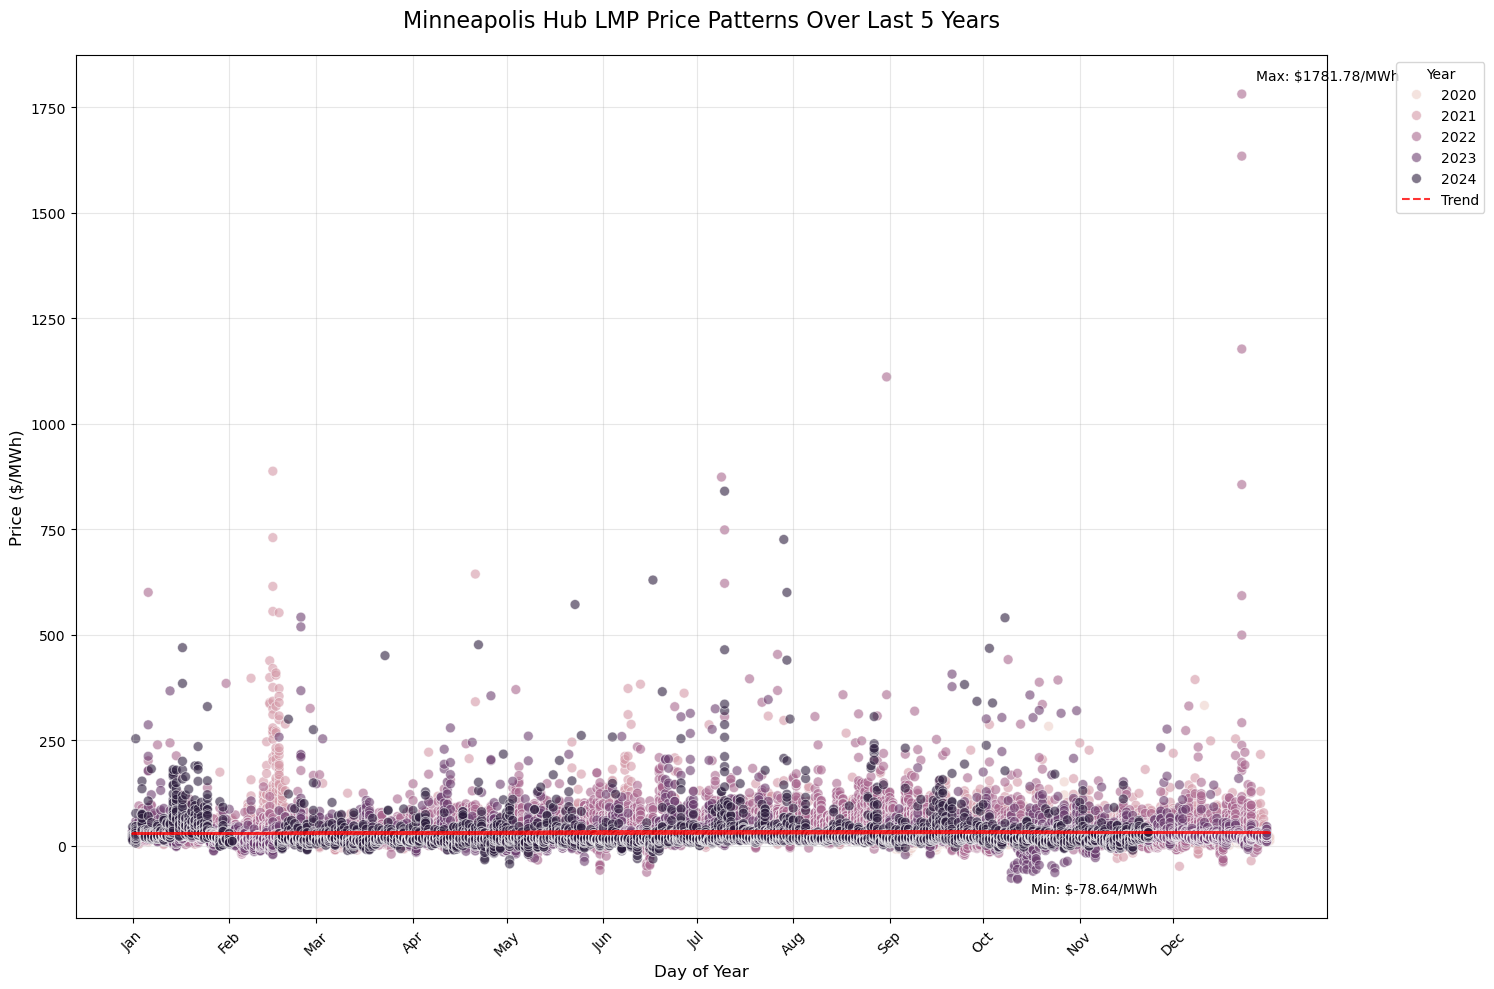


Price Summary Statistics:
count    35792.000000
mean        32.859744
std         37.251783
min        -78.640000
25%         18.107500
50%         24.900000
75%         37.972500
max       1781.780000
Name: Minnesota Hub LMP, dtype: float64
Plot saved as miso_lmp_hourly_data_minnesota.png


In [19]:

def create_price_dot_plot(df, output_file='miso_lmp_hourly_data_minnesota.png'):
    """
    Creates a dot plot of price patterns over the last 5 years,
    saves it to a file, and displays it in the notebook
    
    Parameters:
    df: DataFrame with price data
    output_file: str, name of file to save the plot
    """
    # Convert Price column name to shorter version for plotting
    price_col = 'Minnesota Hub LMP'
    date_col = 'Local Date'
    
    # Ensure date column is datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Filter last 5 years
    five_years_ago = datetime.now() - timedelta(days=5*365)
    df_filtered = df[df[date_col] >= five_years_ago].copy()
    
    # Create figure and axis with specified size
    plt.figure(figsize=(15, 10))
    
    # Create the main dot plot
    sns.scatterplot(
        data=df_filtered,
        x=df_filtered[date_col].dt.dayofyear,
        y=df_filtered[price_col],
        hue=df_filtered[date_col].dt.year,
        alpha=0.6,
        s=50
    )
    
    # Add trend line
    x = df_filtered[date_col].dt.dayofyear
    y = df_filtered[price_col]
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", alpha=0.8, label='Trend')
    
    # Customize the plot
    plt.title('Minneapolis Hub LMP Price Patterns Over Last 5 Years', 
              fontsize=16, pad=20)
    plt.xlabel('Day of Year', fontsize=12)
    plt.ylabel('Price ($/MWh)', fontsize=12)
    
    # Add month indicators on x-axis
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_positions = [1, 32, 60, 91, 121, 152, 
                      182, 213, 244, 274, 305, 335]
    plt.xticks(month_positions, months, rotation=45)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Enhance legend
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add annotations for extreme prices
    max_price_idx = df_filtered[price_col].idxmax()
    min_price_idx = df_filtered[price_col].idxmin()
    
    plt.annotate(f'Max: ${df_filtered[price_col].max():.2f}/MWh',
                xy=(df_filtered.loc[max_price_idx, date_col].dayofyear,
                    df_filtered.loc[max_price_idx, price_col]),
                xytext=(10, 10), textcoords='offset points')
    
    plt.annotate(f'Min: ${df_filtered[price_col].min():.2f}/MWh',
                xy=(df_filtered.loc[min_price_idx, date_col].dayofyear,
                    df_filtered.loc[min_price_idx, price_col]),
                xytext=(10, -10), textcoords='offset points')
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    # Display the plot in notebook
    plt.show()
    
    # Print summary statistics
    print("\nPrice Summary Statistics:")
    print(df_filtered[price_col].describe())
    
    return f"Plot saved as {output_file}"

# Read the data, create and save the plot
try:
    # Make sure you've run %matplotlib inline at the start of your notebook
    df = pd.read_csv('miso_lmp_hourly_data_minnesota.csv')
    result = create_price_dot_plot(df)
    print(result)  # Confirms the file was saved
except FileNotFoundError:
    print("Error: CSV file not found. Please check the file path.")
except KeyError as e:
    print(f"Error: Required column not found in CSV: {str(e)}")
except Exception as e:
    print(f"Error creating plot: {str(e)}")


Monthly Statistics:

Median Prices by Month:
Month
Jan    25.74
Feb    23.68
Mar    21.82
Apr    23.60
May    22.56
Jun    24.46
Jul    29.32
Aug    30.88
Sep    25.90
Oct    26.54
Nov    23.73
Dec    24.95
Name: median, dtype: float64

Mean Prices by Month:
Month
Jan    32.73
Feb    36.48
Mar    23.87
Apr    29.56
May    29.63
Jun    34.59
Jul    40.42
Aug    42.81
Sep    33.16
Oct    33.15
Nov    28.41
Dec    33.48
Name: mean, dtype: float64


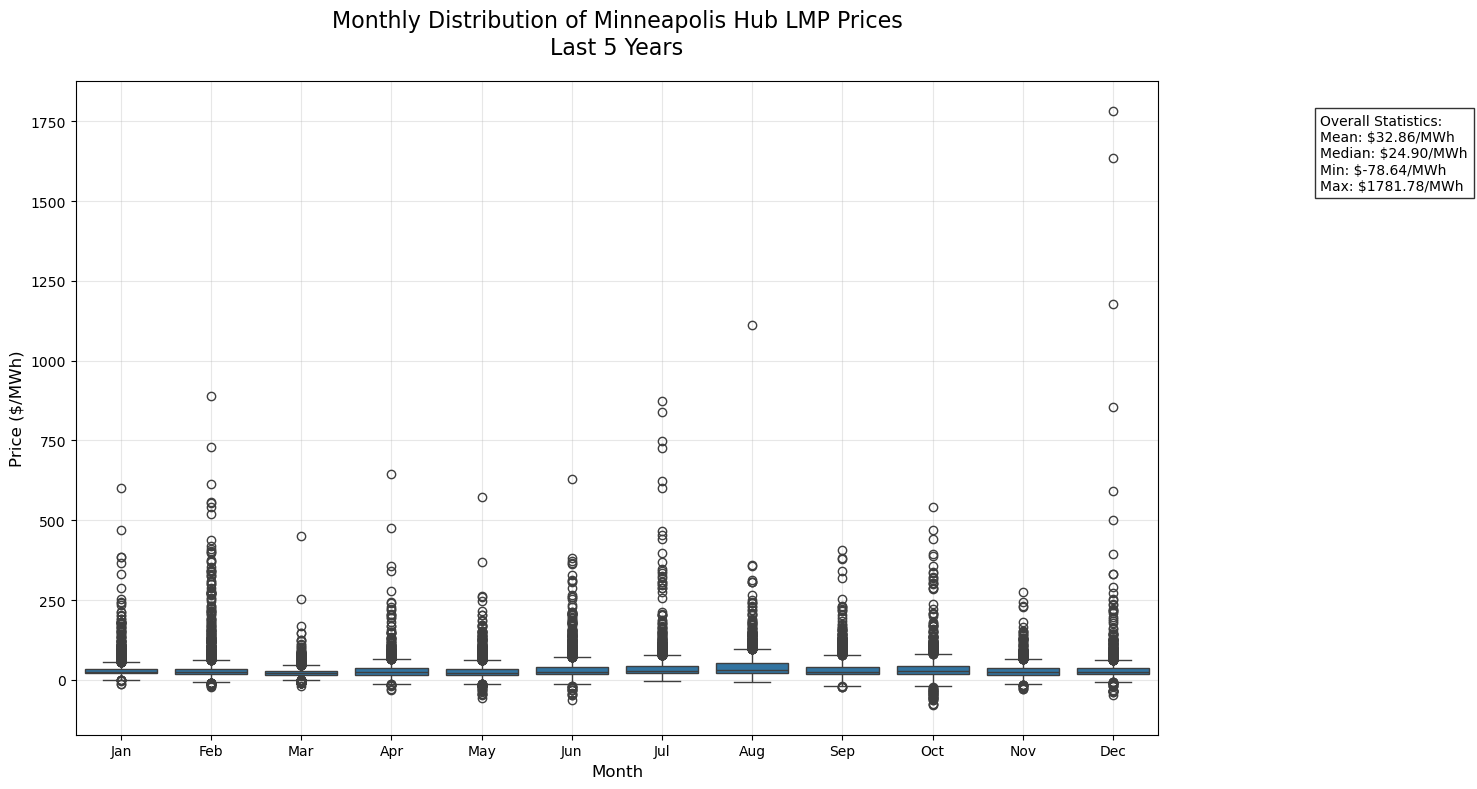

Plot saved as miso_lmp_monthly_box.png


In [20]:
def create_monthly_box_plot(df, output_file='miso_lmp_monthly_box.png'):
    """
    Creates a box and whisker plot of price patterns by month,
    saves it to a file, and displays it in the notebook
    
    Parameters:
    df: DataFrame with price data
    output_file: str, name of file to save the plot
    """
    # Convert Price column name to shorter version for plotting
    price_col = 'Minnesota Hub LMP'
    date_col = 'Local Date'
    
    # Ensure date column is datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Filter last 5 years
    five_years_ago = datetime.now() - timedelta(days=5*365)
    df_filtered = df[df[date_col] >= five_years_ago].copy()
    
    # Add month name column
    df_filtered['Month'] = df_filtered[date_col].dt.strftime('%b')
    
    # Create figure and axis with specified size
    plt.figure(figsize=(15, 8))
    
    # Create the box plot
    sns.boxplot(
        data=df_filtered,
        x='Month',
        y=price_col,
        order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        whis=1.5  # Define whiskers at 1.5 IQR
    )
    
    # Customize the plot
    plt.title('Monthly Distribution of Minneapolis Hub LMP Prices\nLast 5 Years', 
              fontsize=16, pad=20)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Price ($/MWh)', fontsize=12)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)
    
    # Add statistical annotations
    monthly_stats = df_filtered.groupby('Month')[price_col].agg(['mean', 'median'])
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_stats = monthly_stats.reindex(month_order)
    
    # Print monthly statistics
    print("\nMonthly Statistics:")
    print("\nMedian Prices by Month:")
    print(monthly_stats['median'].round(2))
    print("\nMean Prices by Month:")
    print(monthly_stats['mean'].round(2))
    
    # Add overall statistics annotation to plot
    stats_text = (f"Overall Statistics:\n"
                 f"Mean: ${df_filtered[price_col].mean():.2f}/MWh\n"
                 f"Median: ${df_filtered[price_col].median():.2f}/MWh\n"
                 f"Min: ${df_filtered[price_col].min():.2f}/MWh\n"
                 f"Max: ${df_filtered[price_col].max():.2f}/MWh")
    
    plt.text(1.15, 0.95, stats_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    # Display the plot in notebook
    plt.show()
    
    return f"Plot saved as {output_file}"

# Read the data, create and save the plot
try:
    df = pd.read_csv('miso_lmp_hourly_data_minnesota.csv')
    result = create_monthly_box_plot(df)
    print(result)  # Confirms the file was saved
except FileNotFoundError:
    print("Error: CSV file not found. Please check the file path.")
except KeyError as e:
    print(f"Error: Required column not found in CSV: {str(e)}")
except Exception as e:
    print(f"Error creating plot: {str(e)}")

In [5]:
def process_temp_files(directory_path='.'):
    """
    Reads all hourly temp CSV files and properly parses columns.
    
    Parameters:
    directory_path (str): Path to directory containing the CSV files
    
    Returns:
    pandas.DataFrame: Combined DataFrame with properly formatted columns
    """
    file_pattern = os.path.join(directory_path, 'miso_temp_hr_*.csv')
    files = glob.glob(file_pattern)
    
    if not files:
        raise ValueError(f"No matching files found in {directory_path}")
    
    dfs = []
    
    for file in files:
        try:
            # Read the raw text first to inspect the structure
            with open(file, 'r') as f:
                first_lines = [next(f) for _ in range(5)]
                
            # Count the number of columns based on the first data line
            num_columns = len(first_lines[3].split(','))
            print(f"\nFile: {file}")
            print(f"Number of columns detected: {num_columns}")
            print("First few lines:")
            for line in first_lines:
                print(line.strip())
            
            # Read the CSV with specific parameters
            df = pd.read_csv(
                file,
                delimiter=',',          # Use comma as delimiter
                skiprows=3,            # Skip the header rows
                header=0,              # First row after skipped rows is header
                skip_blank_lines=True,
                on_bad_lines='skip'    # Skip problematic lines
            )
            
            # Clean up column names
            df.columns = df.columns.str.strip()
            
            # Add source file information
            df['source_file'] = os.path.basename(file)
            
            print(f"\nColumns found in {file}:")
            for col in df.columns:
                print(f"- {col}")
            
            print(f"Shape of DataFrame: {df.shape}")
            dfs.append(df)
            
        except Exception as e:
            print(f"Error reading file {file}: {str(e)}")
            continue
    
    if not dfs:
        raise ValueError("No files were successfully processed")
    
    # Combine all DataFrames
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Convert date/time columns if they exist
    date_columns = [col for col in combined_df.columns if 'date' in col.lower() or 'time' in col.lower()]
    for col in date_columns:
        try:
            combined_df[col] = pd.to_datetime(combined_df[col])
        except:
            pass
    
    return combined_df

# Example usage
if __name__ == "__main__":
    try:
        df = process_temp_files()
        
        print("\nFinal combined dataset:")
        print(f"Total rows: {len(df)}")
        print("\nColumns in final dataset:")
        for col in df.columns:
            print(f"- {col}")
        
        print("\nFirst few rows:")
        print(df.head())
        
        output_file = 'combined_temp_data.csv'
        df.to_csv(output_file, index=False)
        print(f"\nData saved to '{output_file}'")
        
    except Exception as e:
        print(f"Error processing files: {str(e)}")


File: .\miso_temp_hr_2020.csv
Number of columns detected: 11
First few lines:
MISO Hourly Temperatures (Fahrenheit) in Major Cities
Hourly temperature data for major cities
Source: EIA collected from NOAA
Indianapolis Temperature (Fahrenheit),Indianapolis Temperature Observation Time (Eastern Standard),Minneapolis Temperature (Fahrenheit),Minneapolis Temperature Observation Time (Eastern Standard),New Orleans International Airport Temperature (Fahrenheit),New Orleans International Airport Temperature Observation Time (Eastern Standard),UTC Timestamp (Interval Ending),Local Timestamp Eastern Standard Time (Interval Beginning),Local Timestamp Eastern Standard Time (Interval Ending),Local Date,Hour Number
34.0,2020-01-01 00:54:00,14.0,2020-01-01 00:53:00,50.0,2020-01-01 00:53:00,2020-01-01 06:00:00,2020-01-01 00:00:00,2020-01-01 01:00:00,2020-01-01,1

Columns found in .\miso_temp_hr_2020.csv:
- Indianapolis Temperature (Fahrenheit)
- Indianapolis Temperature Observation Time (Eastern Sta

In [6]:
def process_combined_temp_file(filepath='combined_temp_data.csv'):
    """
    Reads the combined TEMP data file and extracts specific columns with robust datetime parsing.
    
    Parameters:
    filepath (str): Path to the combined CSV file
    
    Returns:
    pandas.DataFrame: DataFrame with selected columns and properly parsed datetimes
    """
    # Define the columns we want to keep
    columns_to_keep = [
        'Minneapolis Temperature (Fahrenheit)',
        'Minneapolis Temperature Observation Time (Eastern Standard)',
        'UTC Timestamp (Interval Ending)',
        'Local Timestamp Eastern Standard Time (Interval Beginning)',
        'Local Timestamp Eastern Standard Time (Interval Ending)',
        'Local Date',
        'Hour Number',
        'source_file'
    ]
    
    try:
        # Read the combined CSV file
        df = pd.read_csv(filepath, usecols=columns_to_keep)
        
        # Clean up column names
        df.columns = df.columns.str.strip()
        
        # Dictionary of possible date formats to try
        date_formats = [
            '%Y-%m-%d %H:%M:%S',  # 2024-01-01 06:00:00
            '%m/%d/%Y %H:%M',     # 1/1/2024 6:00
            '%Y-%m-%d',           # 2024-01-01
            '%m/%d/%Y'            # 1/1/2024
        ]
        
        # Function to try multiple date formats
        def parse_datetime(date_str):
            if pd.isna(date_str):
                return pd.NaT
            
            for fmt in date_formats:
                try:
                    return pd.to_datetime(date_str, format=fmt)
                except:
                    continue
            
            # If no format works, try pandas default parser
            try:
                return pd.to_datetime(date_str)
            except:
                print(f"Warning: Could not parse date string: {date_str}")
                return pd.NaT

        # Convert timestamp columns to datetime
        timestamp_columns = [
            'UTC Timestamp (Interval Ending)',
            'Local Timestamp Eastern Standard Time (Interval Beginning)',
            'Local Timestamp Eastern Standard Time (Interval Ending)',
            'Local Date'
        ]
        
        for col in timestamp_columns:
            if col in df.columns:
                df[col] = df[col].apply(parse_datetime)
                
                # Report parsing success rate
                null_count = df[col].isna().sum()
                total_count = len(df)
                success_rate = ((total_count - null_count) / total_count) * 100
                print(f"Column '{col}' parsing success rate: {success_rate:.2f}%")
        
        # Ensure Hour Number is integer
        df['Hour Number'] = pd.to_numeric(df['Hour Number'], errors='coerce').astype('Int64')
        
        # Add data quality checks
        print("\nData Quality Report:")
        print("-" * 50)
        
        # Check for missing values
        missing_values = df.isnull().sum()
        print("\nMissing values per column:")
        print(missing_values[missing_values > 0])
        
        # Check temperature range
        temp_col = 'Minneapolis Temperature (Fahrenheit)'
        if temp_col in df.columns:
            temp_stats = df[temp_col].describe()
            print(f"\nTemperature statistics:")
            print(f"Min: {temp_stats['min']:.1f}°F")
            print(f"Max: {temp_stats['max']:.1f}°F")
            print(f"Mean: {temp_stats['mean']:.1f}°F")
            
            # Flag suspicious temperatures
            extreme_temps = df[
                (df[temp_col] < -50) | 
                (df[temp_col] > 120)
            ]
            if len(extreme_temps) > 0:
                print(f"\nWarning: Found {len(extreme_temps)} suspicious temperature readings!")
        
        return df
        
    except Exception as e:
        print(f"Error processing file: {str(e)}")
        raise

if __name__ == "__main__":
    try:
        df = process_combined_temp_file()
        
        print("\nProcessed dataset summary:")
        print(f"Total rows: {len(df)}")
        print("\nColumns in dataset:")
        for col in df.columns:
            print(f"- {col}")
        
        print("\nData types:")
        print(df.dtypes)
        
        print("\nFirst few rows:")
        print(df.head())
        
        # Save to new file with selected columns
        output_file = 'temp_data_minnesota_processed.csv'
        df.to_csv(output_file, index=False)
        print(f"\nData saved to '{output_file}'")
        
    except Exception as e:
        print(f"Error: {str(e)}")

Column 'UTC Timestamp (Interval Ending)' parsing success rate: 100.00%
Column 'Local Timestamp Eastern Standard Time (Interval Beginning)' parsing success rate: 100.00%
Column 'Local Timestamp Eastern Standard Time (Interval Ending)' parsing success rate: 100.00%
Column 'Local Date' parsing success rate: 100.00%

Data Quality Report:
--------------------------------------------------

Missing values per column:
Minneapolis Temperature (Fahrenheit)                           63
Minneapolis Temperature Observation Time (Eastern Standard)    63
dtype: int64

Temperature statistics:
Min: -18.9°F
Max: 100.9°F
Mean: 49.5°F

Processed dataset summary:
Total rows: 42371

Columns in dataset:
- Minneapolis Temperature (Fahrenheit)
- Minneapolis Temperature Observation Time (Eastern Standard)
- UTC Timestamp (Interval Ending)
- Local Timestamp Eastern Standard Time (Interval Beginning)
- Local Timestamp Eastern Standard Time (Interval Ending)
- Local Date
- Hour Number
- source_file

Data types:
M

Column 'UTC Timestamp (Interval Ending)' parsing success rate: 100.00%
Column 'Local Timestamp Eastern Standard Time (Interval Beginning)' parsing success rate: 100.00%
Column 'Local Timestamp Eastern Standard Time (Interval Ending)' parsing success rate: 100.00%
Column 'Local Date' parsing success rate: 100.00%

Data Quality Report:
--------------------------------------------------

Missing values per column:
Minneapolis Temperature (Fahrenheit)                           63
Minneapolis Temperature Observation Time (Eastern Standard)    63
dtype: int64

Temperature statistics:
Min: -18.9°F
Max: 100.9°F
Mean: 49.5°F
Error creating plot: SVD did not converge in Linear Least Squares


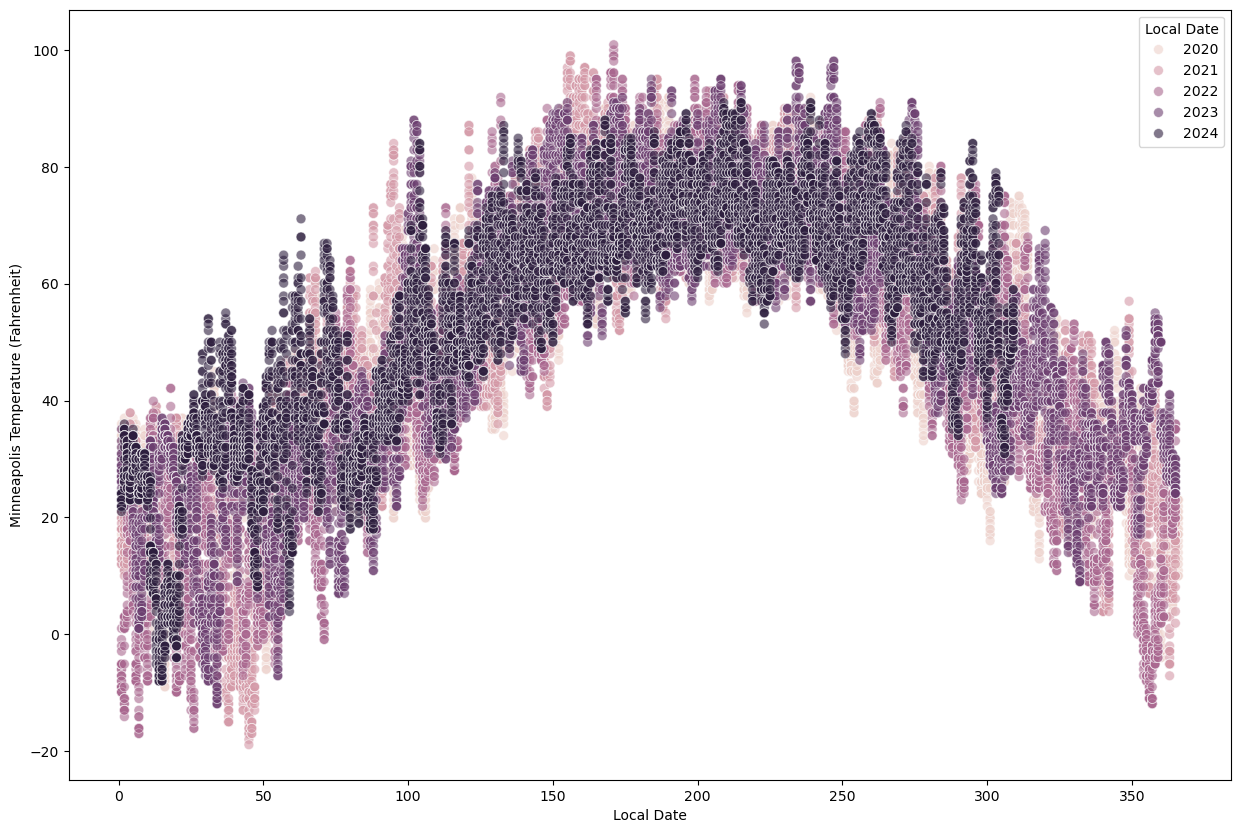

In [7]:
def create_temperature_dot_plot(df, output_file='temperature_patterns1.png'):
    """
    Creates a dot plot of temperature patterns over the last 5 years
    
    Parameters:
    df: DataFrame with temperature data
    output_file: str, name of file to save the plot
    """
    # Convert temperature column name to shorter version for plotting
    temp_col = 'Minneapolis Temperature (Fahrenheit)'
    date_col = 'Local Date'
    
    # Ensure date column is datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Filter last 5 years
    five_years_ago = datetime.now() - timedelta(days=5*365)
    df_filtered = df[df[date_col] >= five_years_ago].copy()
    
    # Create figure and axis with specified size
    plt.figure(figsize=(15, 10))
    
    # Create the main dot plot
    sns.scatterplot(
        data=df_filtered,
        x=df_filtered[date_col].dt.dayofyear,
        y=df_filtered[temp_col],
        hue=df_filtered[date_col].dt.year,
        alpha=0.6,
        s=50
    )
    
    # Add trend line
    x = df_filtered[date_col].dt.dayofyear
    y = df_filtered[temp_col]
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", alpha=0.8, label='Trend')
    
    # Customize the plot
    plt.title('Minneapolis Temperature Patterns Over Last 5 Years', 
              fontsize=16, pad=20)
    plt.xlabel('Day of Year', fontsize=12)
    plt.ylabel('Temperature (°F)', fontsize=12)
    
    # Add month indicators on x-axis
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_positions = [1, 32, 60, 91, 121, 152, 
                      182, 213, 244, 274, 305, 335]
    plt.xticks(month_positions, months, rotation=45)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Add reference lines for common temperature thresholds
    plt.axhline(y=32, color='blue', linestyle=':', alpha=0.5, label='Freezing (32°F)')
    plt.axhline(y=90, color='red', linestyle=':', alpha=0.5, label='Hot Day (90°F)')
    
    # Enhance legend
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add annotations for extreme temperatures
    max_temp_idx = df_filtered[temp_col].idxmax()
    min_temp_idx = df_filtered[temp_col].idxmin()
    
    plt.annotate(f'Max: {df_filtered[temp_col].max():.1f}°F',
                xy=(df_filtered.loc[max_temp_idx, date_col].dayofyear,
                    df_filtered.loc[max_temp_idx, temp_col]),
                xytext=(10, 10), textcoords='offset points')
    
    plt.annotate(f'Min: {df_filtered[temp_col].min():.1f}°F',
                xy=(df_filtered.loc[min_temp_idx, date_col].dayofyear,
                    df_filtered.loc[min_temp_idx, temp_col]),
                xytext=(10, -10), textcoords='offset points')
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()
    
    return f"Plot saved as {output_file}"

# Example usage
if __name__ == "__main__":
    try:
        # Assuming df is your DataFrame from the previous processing
        df = process_combined_temp_file()
        result = create_temperature_dot_plot(df)
        print(result)
        
        # Print some summary statistics
        print("\nTemperature Summary Statistics:")
        temp_col = 'Minneapolis Temperature (Fahrenheit)'
        print(df[temp_col].describe())
        
    except Exception as e:
        print(f"Error creating plot: {str(e)}")

In [8]:
def create_monthly_temperature_plot(df, output_file='monthly_temperature_patterns2.png'):
    """
    Creates a dot plot of temperature patterns over the last 5 years using months on x-axis
    
    Parameters:
    df: DataFrame with temperature data
    output_file: str, name of file to save the plot
    """
    # Convert temperature column name to shorter version for plotting
    temp_col = 'Minneapolis Temperature (Fahrenheit)'
    date_col = 'Local Date'
    
    # Ensure date column is datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Filter last 5 years
    five_years_ago = datetime.now() - timedelta(days=5*365)
    df_filtered = df[df[date_col] >= five_years_ago].copy()
    
    # Add month number and month name columns
    df_filtered['Month'] = df_filtered[date_col].dt.month
    df_filtered['MonthName'] = df_filtered[date_col].dt.strftime('%b')
    df_filtered['Year'] = df_filtered[date_col].dt.year
    
    # Create figure and axis with specified size
    plt.figure(figsize=(15, 10))
    
    # Create the main dot plot
    sns.scatterplot(
        data=df_filtered,
        x='Month',
        y=temp_col,
        hue='Year',
        alpha=0.6,
        s=50
    )
    
    # Add monthly average line
    monthly_avg = df_filtered.groupby('Month')[temp_col].mean()
    plt.plot(monthly_avg.index, monthly_avg.values, 
            'k--', linewidth=2, label='Monthly Average',
            alpha=0.8)
    
    # Calculate and plot confidence interval
    monthly_std = df_filtered.groupby('Month')[temp_col].std()
    plt.fill_between(monthly_avg.index, 
                    monthly_avg.values - monthly_std.values,
                    monthly_avg.values + monthly_std.values,
                    alpha=0.2, color='gray',
                    label='±1 Standard Deviation')
    
    # Customize the plot
    plt.title('Minneapolis Monthly Temperature Patterns\nLast 5 Years', 
              fontsize=16, pad=20)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Temperature (°F)', fontsize=12)
    
    # Set x-axis ticks to month names
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.xticks(range(1, 13), months, rotation=45)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Add reference lines for common temperature thresholds
    plt.axhline(y=32, color='blue', linestyle=':', alpha=0.5, label='Freezing (32°F)')
    plt.axhline(y=90, color='red', linestyle=':', alpha=0.5, label='Hot Day (90°F)')
    
    # Enhance legend
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add annotations for monthly statistics
    for month in range(1, 13):
        month_data = df_filtered[df_filtered['Month'] == month]
        month_max = month_data[temp_col].max()
        month_min = month_data[temp_col].min()
        
        # Add small markers for monthly extremes
        plt.plot(month, month_max, 'r^', markersize=4, alpha=0.7)
        plt.plot(month, month_min, 'bv', markersize=4, alpha=0.7)
    
    # Add text box with summary statistics
    stats_text = (
        f"Overall Statistics:\n"
        f"Max Temp: {df_filtered[temp_col].max():.1f}°F\n"
        f"Min Temp: {df_filtered[temp_col].min():.1f}°F\n"
        f"Mean Temp: {df_filtered[temp_col].mean():.1f}°F"
    )
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=10)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Return summary statistics
    summary_stats = df_filtered.groupby('MonthName')[temp_col].agg([
        'mean', 'std', 'min', 'max'
    ]).round(1)
    
    return summary_stats

# Example usage
if __name__ == "__main__":
    try:
        # Assuming df is your DataFrame from the previous processing
        df = process_combined_temp_file()
        summary_stats = create_monthly_temperature_plot(df)
        
        print("\nMonthly Temperature Statistics:")
        print(summary_stats)
        
    except Exception as e:
        print(f"Error creating plot: {str(e)}")

Column 'UTC Timestamp (Interval Ending)' parsing success rate: 100.00%
Column 'Local Timestamp Eastern Standard Time (Interval Beginning)' parsing success rate: 100.00%
Column 'Local Timestamp Eastern Standard Time (Interval Ending)' parsing success rate: 100.00%
Column 'Local Date' parsing success rate: 100.00%

Data Quality Report:
--------------------------------------------------

Missing values per column:
Minneapolis Temperature (Fahrenheit)                           63
Minneapolis Temperature Observation Time (Eastern Standard)    63
dtype: int64

Temperature statistics:
Min: -18.9°F
Max: 100.9°F
Mean: 49.5°F

Monthly Temperature Statistics:
           mean   std   min    max
MonthName                         
Apr        45.7  11.6  19.9   88.0
Aug        73.1   7.3  53.1   98.1
Dec        25.8  12.7 -11.9   57.0
Feb        20.8  14.8 -18.9   64.9
Jan        19.3  12.3 -17.0   54.0
Jul        75.5   7.7  54.0   95.0
Jun        73.5   9.0  50.0  100.9
Mar        35.3  10.4  -0.9 

In [9]:
def process_wind_files(directory_path='.'):
    """
    Reads all WIND CSV files and properly parses columns.
    
    Parameters:
    directory_path (str): Path to directory containing the CSV files
    
    Returns:
    pandas.DataFrame: Combined DataFrame with properly formatted columns
    """
    file_pattern = os.path.join(directory_path, 'miso_gen_wnd_hr_*.csv')
    files = glob.glob(file_pattern)
    
    if not files:
        raise ValueError(f"No matching files found in {directory_path}")
    
    dfs = []
    
    for file in files:
        try:
            # Read the raw text first to inspect the structure
            with open(file, 'r') as f:
                first_lines = [next(f) for _ in range(5)]
                
            # Count the number of columns based on the first data line
            num_columns = len(first_lines[3].split(','))
            print(f"\nFile: {file}")
            print(f"Number of columns detected: {num_columns}")
            print("First few lines:")
            for line in first_lines:
                print(line.strip())
            
            # Read the CSV with specific parameters
            df = pd.read_csv(
                file,
                delimiter=',',          # Use comma as delimiter
                skiprows=3,            # Skip the header rows
                header=0,              # First row after skipped rows is header
                skip_blank_lines=True,
                on_bad_lines='skip'    # Skip problematic lines
            )
            
            # Clean up column names
            df.columns = df.columns.str.strip()
            
            # Add source file information
            df['source_file'] = os.path.basename(file)
            
            print(f"\nColumns found in {file}:")
            for col in df.columns:
                print(f"- {col}")
            
            print(f"Shape of DataFrame: {df.shape}")
            dfs.append(df)
            
        except Exception as e:
            print(f"Error reading file {file}: {str(e)}")
            continue
    
    if not dfs:
        raise ValueError("No files were successfully processed")
    
    # Combine all DataFrames
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Convert date/time columns if they exist
    date_columns = [col for col in combined_df.columns if 'date' in col.lower() or 'time' in col.lower()]
    for col in date_columns:
        try:
            combined_df[col] = pd.to_datetime(combined_df[col])
        except:
            pass
    
    return combined_df

# Example usage
if __name__ == "__main__":
    try:
        df = process_wind_files()
        
        print("\nFinal combined dataset:")
        print(f"Total rows: {len(df)}")
        print("\nColumns in final dataset:")
        for col in df.columns:
            print(f"- {col}")
        
        print("\nFirst few rows:")
        print(df.head())
        
        output_file = 'combined_wind_data.csv'
        df.to_csv(output_file, index=False)
        print(f"\nData saved to '{output_file}'")
        
    except Exception as e:
        print(f"Error processing files: {str(e)}")


File: .\miso_gen_wnd_hr_2020.csv
Number of columns detected: 6
First few lines:
MISO Hourly Wind Generation (megawatt hour) for MISO System
Hourly system-level wind generation data for MISO
Source: EIA collected from MISO
UTC Timestamp (Interval Ending),Local Timestamp Eastern Standard Time (Interval Beginning),Local Timestamp Eastern Standard Time (Interval Ending),Local Date,Hour Number,MISO Total Wind Generation (MW)
2020-01-01 06:00:00,2020-01-01 00:00:00,2020-01-01 01:00:00,2020-01-01,1,12161.42

Columns found in .\miso_gen_wnd_hr_2020.csv:
- UTC Timestamp (Interval Ending)
- Local Timestamp Eastern Standard Time (Interval Beginning)
- Local Timestamp Eastern Standard Time (Interval Ending)
- Local Date
- Hour Number
- MISO Total Wind Generation (MW)
- source_file
Shape of DataFrame: (8784, 7)

File: .\miso_gen_wnd_hr_2021.csv
Number of columns detected: 6
First few lines:
MISO Hourly Wind Generation (megawatt hour) for MISO System
Hourly system-level wind generation data for MIS

Date range in data:
Start: 2020-01-01 00:00:00
End: 2024-11-04 16:00:00

Years included: [2020, 2021, 2022, 2023, 2024]


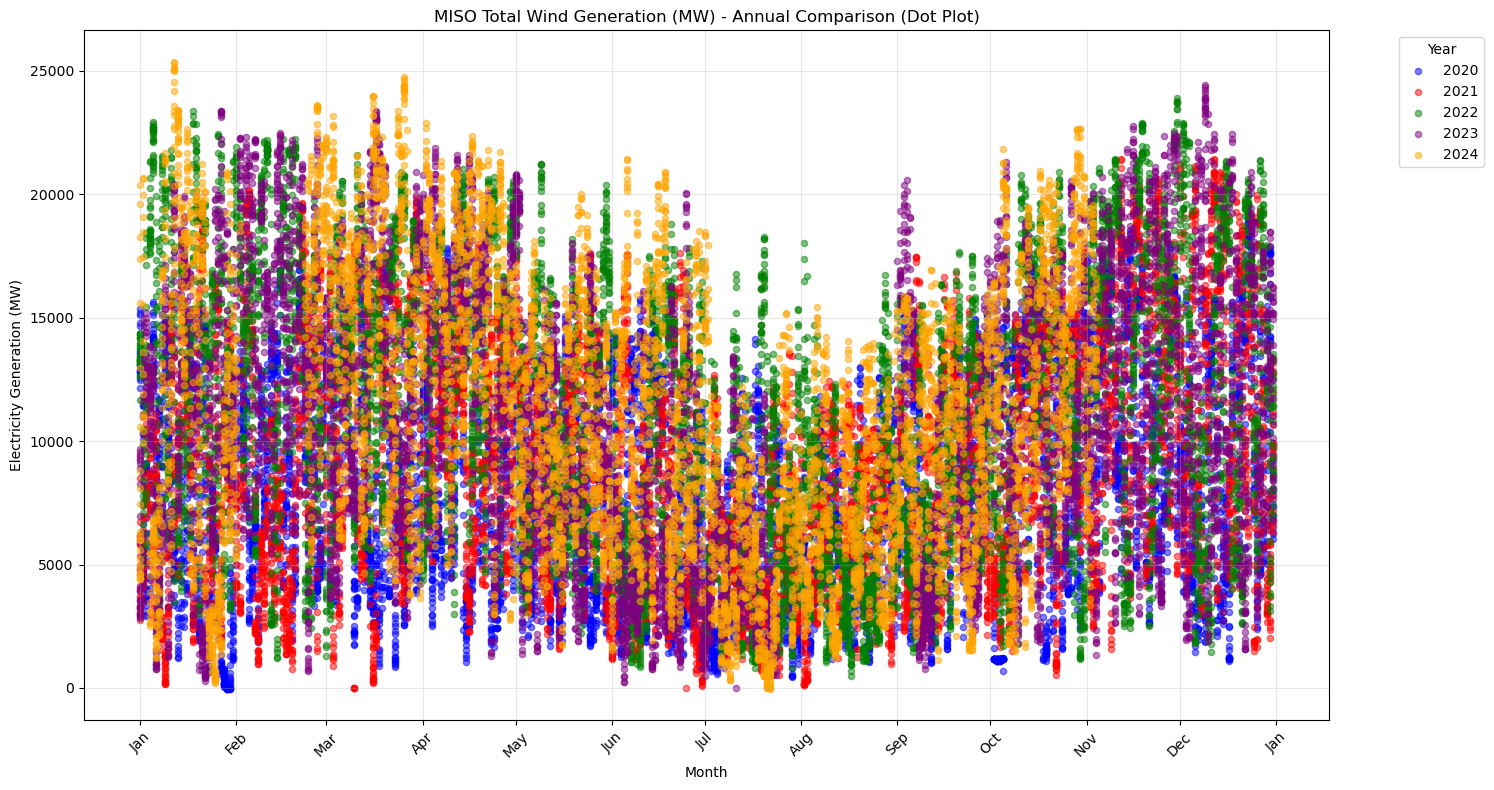

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read the CSV file
df = pd.read_csv('combined_wind_data.csv')

# Convert timestamp to datetime
df['Local Timestamp Eastern Standard Time (Interval Beginning)'] = pd.to_datetime(df['Local Timestamp Eastern Standard Time (Interval Beginning)'])

# Extract month and day for each timestamp (ignore year)
df['month_day'] = df['Local Timestamp Eastern Standard Time (Interval Beginning)'].dt.strftime('%m-%d')
df['year'] = df['Local Timestamp Eastern Standard Time (Interval Beginning)'].dt.year

# Create the plot with a larger figure size for better visibility
plt.figure(figsize=(15, 8))

# Get unique years
years = sorted(df['year'].unique())
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']

# Plot each year as dots
for i, year in enumerate(years):
    year_data = df[df['year'] == year].copy()
    # Convert month-day to datetime for consistent x-axis
    year_data['plot_date'] = pd.to_datetime('2020-' + year_data['month_day'])
    
    # Plot scatter points instead of lines
    plt.scatter(year_data['plot_date'], 
               year_data['MISO Total Wind Generation (MW)'],
               label=str(year),
               color=colors[i % len(colors)],
               alpha=0.5,
               s=20)  # Size of dots

# Format x-axis to show only month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Customize the plot
plt.title('MISO Total Wind Generation (MW) - Annual Comparison (Dot Plot)')
plt.xlabel('Month')
plt.ylabel('Electricity Generation (MW)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)  # Lighter grid for better visibility of points

# Add legend with a better position
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('MISO_wind_generation_dotplot.png', bbox_inches='tight', dpi=300)

# Print date range for verification
print("Date range in data:")
print(f"Start: {df['Local Timestamp Eastern Standard Time (Interval Beginning)'].min()}")
print(f"End: {df['Local Timestamp Eastern Standard Time (Interval Beginning)'].max()}")
print("\nYears included:", sorted(years))

In [24]:
def process_miso_generation(directory_path='.'):
    """
    Reads and analyzes only MISO Total generation data by fuel type.
    
    Parameters:
    directory_path (str): Path to directory containing the CSV files
    
    Returns:
    pandas.DataFrame: DataFrame with MISO Total generation columns
    """
    file_pattern = os.path.join(directory_path, 'miso_gen_all_hr_202*.csv')
    files = glob.glob(file_pattern)
    
    if not files:
        raise ValueError(f"No matching files found in {directory_path}")
    
    dfs = []
    
    for file in files:
        try:
            # Read only MISO Total columns plus timestamps
            df = pd.read_csv(
                file,
                delimiter=',',
                skiprows=3,
                header=0,
                skip_blank_lines=True,
                on_bad_lines='skip'
            )
            
            # Clean up column names
            df.columns = df.columns.str.strip()
            
            # Select only MISO Total columns and timestamp columns
            miso_cols = [col for col in df.columns if 'MISO Total' in col]
            time_cols = [
                'UTC Timestamp (Interval Ending)',
                'Local Timestamp Eastern Standard Time (Interval Beginning)',
                'Local Timestamp Eastern Standard Time (Interval Ending)',
                'Local Date',
                'Hour Number'
            ]
            
            df = df[time_cols + miso_cols]
            
            # Add metadata
            df['source_file'] = os.path.basename(file)
            df['year'] = os.path.basename(file).split('_')[-1].split('.')[0]
            
            print(f"\nProcessed {file}")
            print(f"Shape: {df.shape}")
            dfs.append(df)
            
        except Exception as e:
            print(f"Error reading file {file}: {str(e)}")
            continue
    
    if not dfs:
        raise ValueError("No files were successfully processed")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Convert timestamp columns
    timestamp_cols = [
        'UTC Timestamp (Interval Ending)',
        'Local Timestamp Eastern Standard Time (Interval Beginning)',
        'Local Timestamp Eastern Standard Time (Interval Ending)'
    ]
    
    for col in timestamp_cols:
        if col in combined_df.columns:
            combined_df[col] = pd.to_datetime(combined_df[col])
    
    return combined_df

def generate_miso_statistics(df):
    """
    Generates statistical summary of MISO Total generation by fuel type.
    """
    # Get MISO generation columns
    gen_cols = [col for col in df.columns if 'MISO Total' in col and 'Generation (MW)' in col]
    
    # Calculate basic statistics
    stats = df[gen_cols].describe()
    stats.loc['missing_values'] = df[gen_cols].isnull().sum()
    
    # Calculate fuel mix percentages
    total_col = 'MISO Total Total Generation (MW)'
    if total_col in df.columns:
        print("\nAverage Fuel Mix - MISO Total:")
        avg_total = df[total_col].mean()
        fuel_types = ['Coal', 'Gas', 'Hydro', 'Nuclear', 'Other', 'Wind']
        
        for fuel in fuel_types:
            fuel_col = f'MISO Total {fuel} Generation (MW)'
            if fuel_col in df.columns:
                avg_fuel = df[fuel_col].mean()
                pct = (avg_fuel / avg_total * 100) if avg_total > 0 else 0
                print(f"{fuel}: {pct:.1f}%")
    
    return stats

if __name__ == "__main__":
    try:
        # Process the files
        df = process_miso_generation()
        
        print("\nProcessing complete!")
        print(f"Total rows: {len(df)}")
        print("\nColumns in dataset:")
        for col in df.columns:
            print(f"- {col}")
        
        # Generate and display MISO statistics
        stats = generate_miso_statistics(df)
        print("\nMISO Generation Statistics (MW):")
        print(stats)
        
        # Calculate and display key metrics
        print("\nKey MISO Metrics:")
        miso_total_col = 'MISO Total Total Generation (MW)'
        if miso_total_col in df.columns:
            print(f"Peak Generation: {df[miso_total_col].max():.0f} MW")
            print(f"Average Generation: {df[miso_total_col].mean():.0f} MW")
            print(f"Minimum Generation: {df[miso_total_col].min():.0f} MW")
            
            # Calculate capacity factor for each fuel type
            print("\nCapacity Factors:")
            peak_total = df[miso_total_col].max()
            fuel_types = ['Coal', 'Gas', 'Hydro', 'Nuclear', 'Other', 'Wind']
            for fuel in fuel_types:
                fuel_col = f'MISO Total {fuel} Generation (MW)'
                if fuel_col in df.columns:
                    peak_fuel = df[fuel_col].max()
                    avg_fuel = df[fuel_col].mean()
                    capacity_factor = (avg_fuel / peak_fuel * 100) if peak_fuel > 0 else 0
                    print(f"{fuel}: {capacity_factor:.1f}%")
        
        # Save processed data
        output_file = 'miso_total_generation_data.csv'
        df.to_csv(output_file, index=False)
        print(f"\nData saved to '{output_file}'")
        
    except Exception as e:
        print(f"Error processing files: {str(e)}")


Processed .\miso_gen_all_hr_2020.csv
Shape: (2208, 14)

Processed .\miso_gen_all_hr_2021.csv
Shape: (8758, 15)

Processed .\miso_gen_all_hr_2022.csv
Shape: (8709, 16)

Processed .\miso_gen_all_hr_2023.csv
Shape: (7584, 16)

Processed .\miso_gen_all_hr_2024.csv
Shape: (7272, 16)

Processing complete!
Total rows: 34531

Columns in dataset:
- UTC Timestamp (Interval Ending)
- Local Timestamp Eastern Standard Time (Interval Beginning)
- Local Timestamp Eastern Standard Time (Interval Ending)
- Local Date
- Hour Number
- MISO Total Total Generation (MW)
- MISO Total Coal Generation (MW)
- MISO Total Gas Generation (MW)
- MISO Total Hydro Generation (MW)
- MISO Total Nuclear Generation (MW)
- MISO Total Other Generation (MW)
- MISO Total Wind Generation (MW)
- source_file
- year
- MISO Total Solar Generation (MW)
- MISO Total Storage Generation (MW)

Average Fuel Mix - MISO Total:
Coal: 32.2%
Gas: 34.6%
Hydro: 1.7%
Nuclear: 14.7%
Other: 0.9%
Wind: 15.0%

MISO Generation Statistics (MW):
   

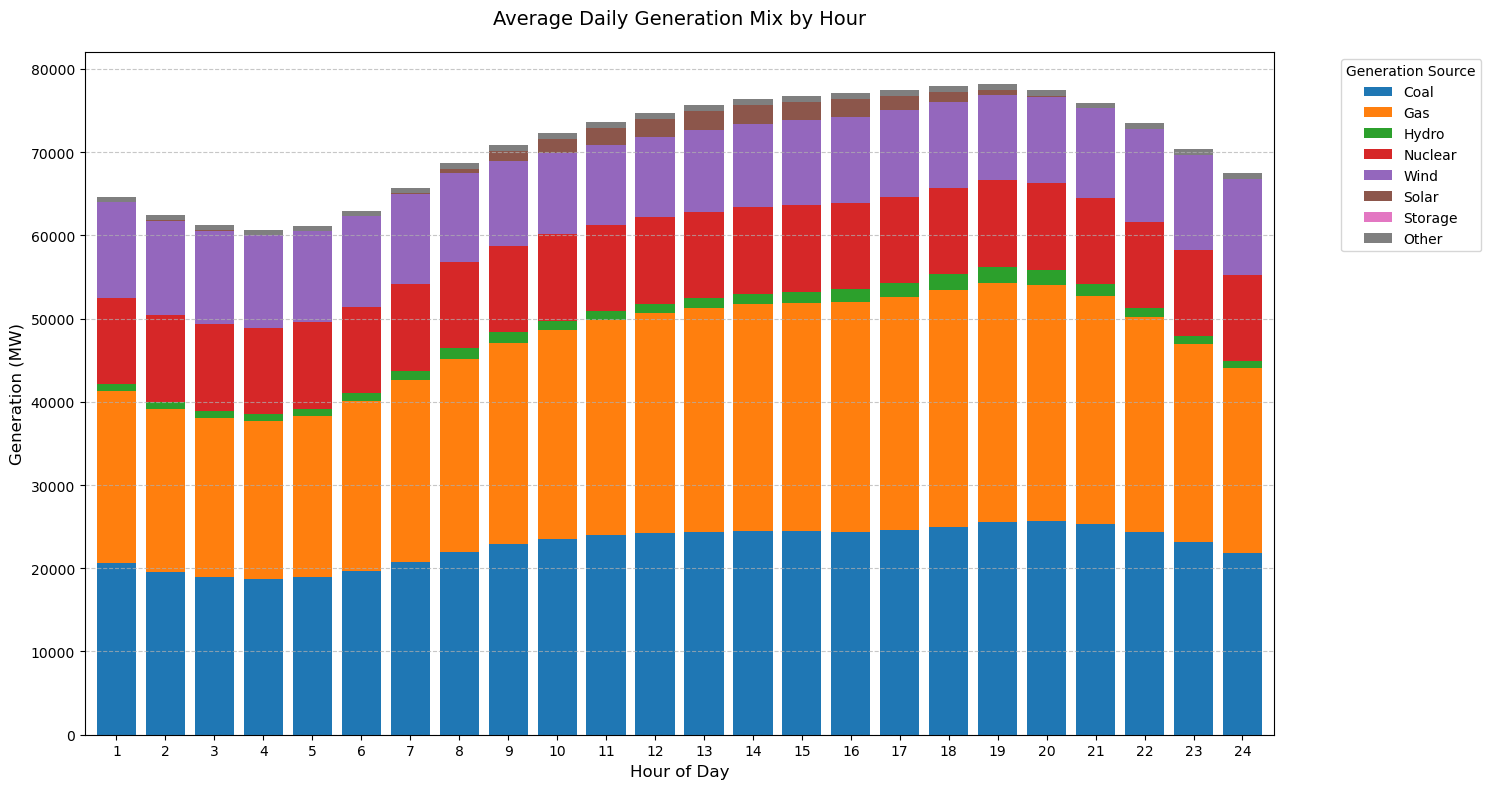

In [26]:

# First, let's identify the generation columns
df = pd.read_csv('miso_total_generation_data.csv')
generation_columns = [
    'MISO Total Coal Generation (MW)',
    'MISO Total Gas Generation (MW)',
    'MISO Total Hydro Generation (MW)',
    'MISO Total Nuclear Generation (MW)',
    'MISO Total Wind Generation (MW)',
    'MISO Total Solar Generation (MW)',
    'MISO Total Storage Generation (MW)',
    'MISO Total Other Generation (MW)'
]

# Group by hour and calculate mean for each generation type
hourly_avg = df.groupby('Hour Number')[generation_columns].mean()

# Create more readable labels for the legend
labels = [col.replace('MISO Total ', '').replace(' Generation (MW)', '') for col in generation_columns]

# Create the stacked bar chart
ax = hourly_avg.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 8),
    width=0.8
)

# Customize the chart
plt.title('Average Daily Generation Mix by Hour', pad=20, size=14)
plt.xlabel('Hour of Day', size=12)
plt.ylabel('Generation (MW)', size=12)
plt.legend(title='Generation Source', bbox_to_anchor=(1.05, 1), loc='upper left', labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()